## Labwork 5 | Convex hull of a set.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

def to_cartesian(p):
    return p[:2] / p[2]

def plot(*shapes,
         size=6,
         lim=15,
         major=5,
         with_points=True,
         point_size=5,
         close=True,
         from_origin=False,
         show_legend=False,
         **common_plot_kw):
    fig, ax = plt.subplots(figsize=(size, size))

    for item in shapes:
        if isinstance(item, tuple):
            shape, plot_kw = item
        else:
            shape, plot_kw = item, {}

        shape = np.asarray(shape)
        x = shape[:, 0] / shape[:, 2]
        y = shape[:, 1] / shape[:, 2]

        if close:
            xx = np.append(x, x[0])
            yy = np.append(y, y[0])
        else:
            xx, yy = x, y

        if "label" in plot_kw:
            show_legend = True

        ax.plot(xx, yy, **({"linewidth": 1.6} | common_plot_kw | plot_kw))

        if with_points:
            ax.scatter(x, y, s=point_size, zorder=3)

    ax.set_aspect("equal")

    if from_origin:
        ax.set_xlim(0, lim)
        ax.set_ylim(0, lim)
        major_ticks = np.arange(0, lim + 1, major)
        minor_ticks = np.arange(0, lim + 1, 1)
    else:
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        major_ticks = np.arange(-lim, lim + 1, major)
        minor_ticks = np.arange(-lim, lim + 1, 1)

    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which="major", linestyle="-", linewidth=0.8)
    ax.grid(which="minor", linestyle=":", linewidth=0.5)

    if show_legend:
        ax.legend()

    plt.show()




### Task 1

Задайте множество $E$ точек $P_1, P_2, ..., P_n (n \ge 10)$

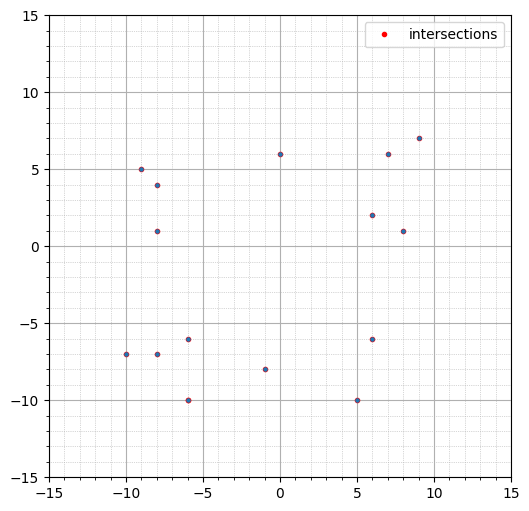

In [53]:
np.random.seed(43)
points_2d = np.random.randint(-10, 10, size=(15, 2))
points = np.hstack([points_2d, np.ones((points_2d.shape[0], 1))])

plot((points, {"color": "red", "label": "intersections", "marker": ".", "linestyle": "None"}))

#### Постройте выпуклую оболочку множества $E$:
* алгоритм Джарвиса
* алгоритм Грэхема

##### Алгоритм Джарвиса

In [54]:
def orientation(p, q, r):
    # Returns the orientation of the triplet (p, q, r)
    val = (q[1] - p[1]) * (r[0] - q[0]) - \
          (q[0] - p[0]) * (r[1] - q[1])
    if val == 0:
        return 0  # colinear
    elif val > 0:
        return 1  # clockwise
    else:
        return 2  # counterclockwise

def jarvis_march(points):
    n = len(points)
    if n < 3:
        return points

    hull = []

    l = np.argmin(points[:, 0])
    p = l
    while True:
        hull.append(p)
        q = (p + 1) % n
        for i in range(n):
            if orientation(points[p][:2], points[i][:2], points[q][:2]) == 2:
                q = i
        p = q
        if p == l:
            break
    return points[hull]

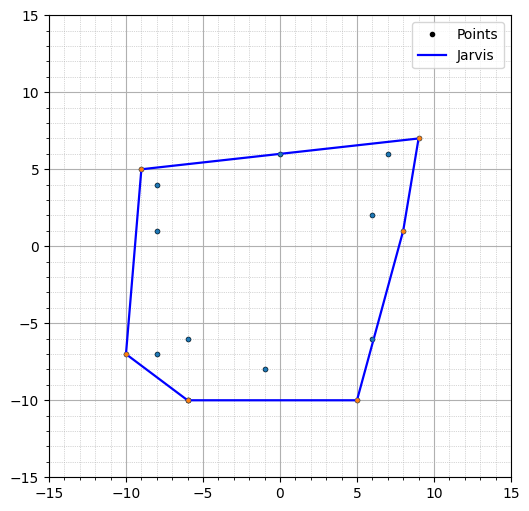

In [55]:

jarvis_hull = jarvis_march(points)
segment_jarvis = (jarvis_hull, {"label": "Jarvis", "color": "blue"})

plot((points, {"label": "Points", "linestyle": "None", "marker": ".", "color": "black"}),
     segment_jarvis,
     from_origin=False,
     close=True,
     show_legend=True)


In [56]:
def graham_scan(points):
    def polar_angle(p0, p1):
        return np.arctan2(p1[1] - p0[1], p1[0] - p0[0])

    def keep_left(hull, r):
        while len(hull) > 1 and orientation(hull[-2][:2], hull[-1][:2], r[:2]) != 2:
            hull.pop()
        hull.append(r)
        return hull

    points_sorted = sorted(points, key=lambda p: (p[1], p[0]))
    pivot = points_sorted[0]
    sorted_points = sorted(points_sorted[1:], key=lambda p: polar_angle(pivot[:2], p[:2]))
    hull = [pivot]
    for p in sorted_points:
        hull = keep_left(hull, p)
    return np.array(hull)

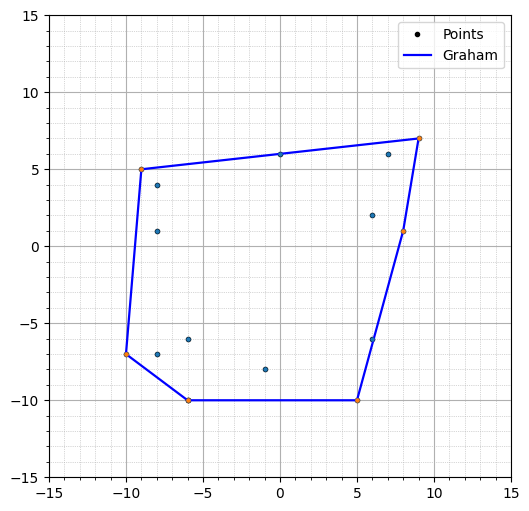

In [57]:
graham_hull = graham_scan(points)
segment_graham = (graham_hull, {"label": "Graham", "color": "blue"})

plot((points, {"label": "Points", "linestyle": "None", "marker": ".", "color": "black"}),
     segment_graham,
     from_origin=False,
     close=True,
     show_legend=True)

In [58]:
def perimeter(polygon):
  return sum(np.linalg.norm(polygon[i][:2] - polygon[(i + 1) % len(polygon)][:2]) for i in range(len(polygon)))

def area(polygon):
  x = polygon[:, 0]
  y = polygon[:, 1]
  return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

graham_perimeter = perimeter(graham_hull)
graham_area = area(graham_hull)

{
  "Perimeter": int(graham_perimeter), "Area": int(graham_area)
}


{'Perimeter': 63, 'Area': 260}

### Task 2

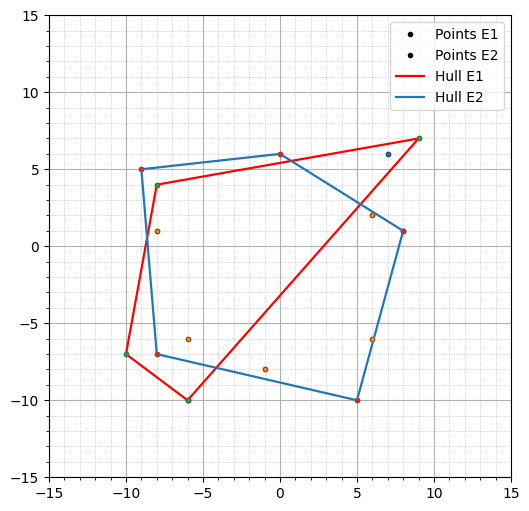

In [68]:
points_one = points[:5]
points_two = points[5:]

hull_one = graham_scan(points_one)
hull_two = graham_scan(points_two)

plot(
  (points_one, {"label": "Points E1", "linestyle": "None", "marker": ".", "color": "black"}),
  (points_two, {"label": "Points E2", "linestyle": "None", "marker": ".", "color": "black"}),
  (hull_one, {"label": "Hull E1", "color": "red"}),
  (hull_two, {"label": "Hull E2"}),
)

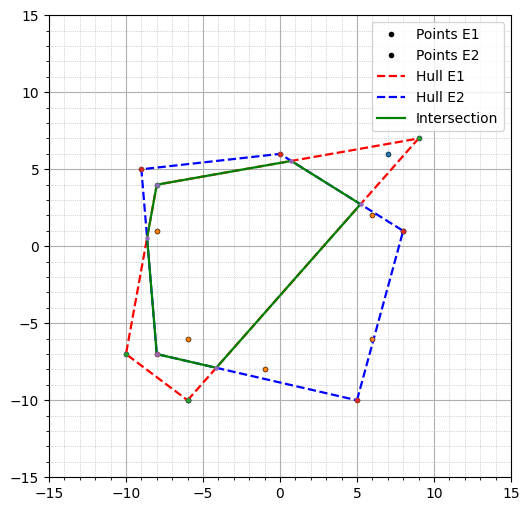

In [ ]:
def sutherland_hodgman(subject_polygon, clip_polygon):
    def inside(p, edge_start, edge_end):
        return (edge_end[0] - edge_start[0]) * (p[1] - edge_start[1]) - \
               (edge_end[1] - edge_start[1]) * (p[0] - edge_start[0]) >= 0

    def compute_intersection(p1, p2, cp1, cp2):
        dc = cp1 - cp2
        dp = p1 - p2
        n1 = cp1[0] * cp2[1] - cp1[1] * cp2[0]
        n2 = p1[0] * p2[1] - p1[1] * p2[0]
        denom = dc[0] * dp[1] - dc[1] * dp[0]
        if denom == 0:
            return p2
        x = (n1 * dp[0] - n2 * dc[0]) / denom
        y = (n1 * dp[1] - n2 * dc[1]) / denom
        return np.array([x, y])

    output_list = subject_polygon[:, :2]
    cp1 = clip_polygon[-1, :2]

    for cp2 in clip_polygon[:, :2]:
        input_list = output_list
        output_list = []
        if not len(input_list):
            break
        s = input_list[-1]
        for e in input_list:
            if inside(e, cp1, cp2):
                if not inside(s, cp1, cp2):
                    output_list.append(compute_intersection(s, e, cp1, cp2))
                output_list.append(e)
            elif inside(s, cp1, cp2):
                output_list.append(compute_intersection(s, e, cp1, cp2))
            s = e
        cp1 = cp2

    if len(output_list):
        result = np.hstack([np.array(output_list), np.ones((len(output_list), 1))])
    else:
        result = np.zeros((0, 3))
    return result

# Compute the intersection polygon
intersection_poly = sutherland_hodgman(hull_one, hull_two)

# Plot everything including the intersection
plot(
    (points_one, {"label": "Points E1", "linestyle": "None", "marker": ".", "color": "black"}),
    (points_two, {"label": "Points E2", "linestyle": "None", "marker": ".", "color": "black"}),
    (hull_one, {"label": "Hull E1", "color": "red", "linestyle": "--"}),
    (hull_two, {"label": "Hull E2", "color": "blue", "linestyle": "--"}),
    (intersection_poly, {"label": "Intersection", "color": "yellow"}),
    show_legend=True
)
